## Check if base case after day 4 is in the advective regime

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns
import xarray as xr
import canyon_tools.savitzky_golay as sg

In [2]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('talk')

# Set necessary grid variables and grid file
grid = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc')
rc = grid.RC


In [3]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
Hh = 97.5 # 
Hr = 130.0 # rim depth at dn station
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    retun(f*L/(N))
    
def Z(U=0.36,L=6400.0,N=5.5E-3,R=5000.0):
    '''Depth of upwelling as scaled in Allen and Hickey 2010'''
    return((1.4*U*(L**(1/2)))/(Nos*(R**(1/2))))

def Ro(U=0.36,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the hability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Rw(U=0.36,f=9.66E-5,Wsb=13000.0): 
    '''Rossby number using width at shelf break as length scale'''
    return(U/(f*Wsb))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [4]:
def conc_to_depth(conc,z1=2.5,z2=1190.0,conc1=2.0,conc2=45.0):
    ''' conc: float, the concentration of which to calculate the initial depth
        z1=2.5 m
        z2=1190.0 m
        conc1=2.0 [C]
        conc2=45.0 [C] (default values for tracer profile in base case).
        return: float. Initial depth at which to find concentration conc. 
        Note that depth of upwelling is this depth minus the depth of the canyon head.'''
    
    return(((z2-z1)/(conc2-conc1))*(conc-conc1)+z1)


In [8]:
def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr:tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcFiltered = concentration at cell closest to bottom(nt,ny,nx)
       Area of domain
       '''
    
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area)

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)



## Depth of upwelling vs. incoming velocity

In [18]:
# Get maximum concentration on shelf per day
ptrac_base_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
pt_base = xr.open_dataset(ptrac_base_file)

ConcFiltSq, AreaSq = ConcArea(pt_base.Tr2.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
max_conc_base = np.max(np.max(ConcFiltSq,1),1)

ptrac_low_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR/run01/ptracersGlob.nc' 
pt_low = xr.open_dataset(ptrac_low_file)

ConcFiltSq, AreaSq = ConcArea(pt_low.Tr2.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
max_conc_low = np.max(np.max(ConcFiltSq,1),1)

ptrac_lower_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR/run01/ptracersGlob.nc' 
pt_lower = xr.open_dataset(ptrac_lower_file)

ConcFiltSq, AreaSq = ConcArea(pt_lower.Tr2.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
max_conc_lower = np.max(np.max(ConcFiltSq,1),1)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)


In [19]:
# State files
state_file_bf = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state_bf = xr.open_dataset(state_file_bf)


state_filelowersr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR/run01/stateGlob.nc'
state_lowersr01 = xr.open_dataset(state_filelowersr)

state_filelowsr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR/run01/stateGlob.nc'
state_lowsr01 = xr.open_dataset(state_filelowsr)


In [20]:
# Get incoming U
U_in_base = state_bf.U.isel(Xp1=120, Z=slice(16,21),Y=slice(230,251))
U_in_lowsr = state_lowsr01.U.isel(Xp1=120, Z=slice(16,21),Y=slice(230,251))
U_in_lowersr = state_lowersr01.U.isel(Xp1=120, Z=slice(16,21),Y=slice(230,251))

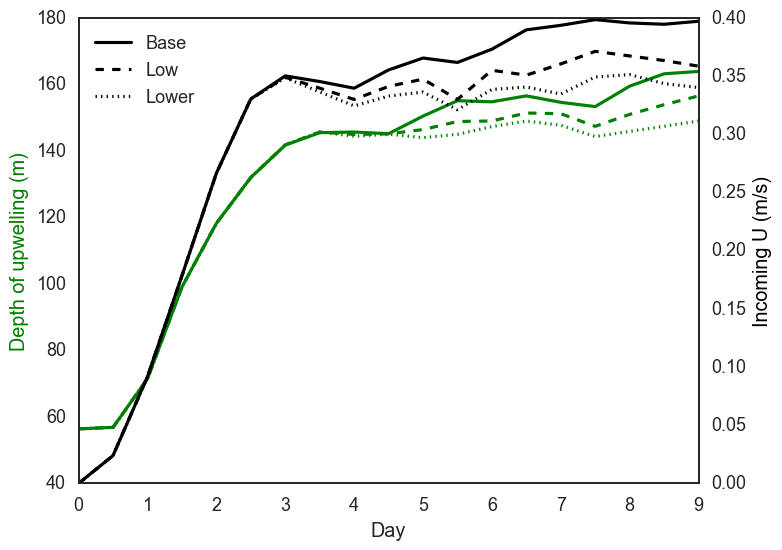

In [50]:
fig,ax1 = plt.subplots(1,1,figsize=(8,6))

ax2 = ax1.twinx()

ax1.plot(np.arange(19)/2,conc_to_depth(max_conc_base)-Hh, 'g-')
ax2.plot(np.arange(19)/2, np.mean(np.mean(U_in_base,axis=1),axis=1), 'k-',label = 'Base')

ax1.plot(np.arange(19)/2,conc_to_depth(max_conc_low)-Hh,'g--')
ax2.plot(np.arange(19)/2, np.mean(np.mean(U_in_lowsr,axis=1),axis=1), 'k--',label = 'Low')

ax1.plot(np.arange(19)/2,conc_to_depth(max_conc_lower)-Hh, 'g:')
ax2.plot(np.arange(19)/2, np.mean(np.mean(U_in_lowersr,axis=1),axis=1), 'k:',label = 'Lower')

ax1.set_xlabel('Day')
ax1.set_ylabel('Depth of upwelling (m)', color='g')
ax2.set_ylabel('Incoming U (m/s)', color='k')


ax2.legend(loc=0)

plt.show()


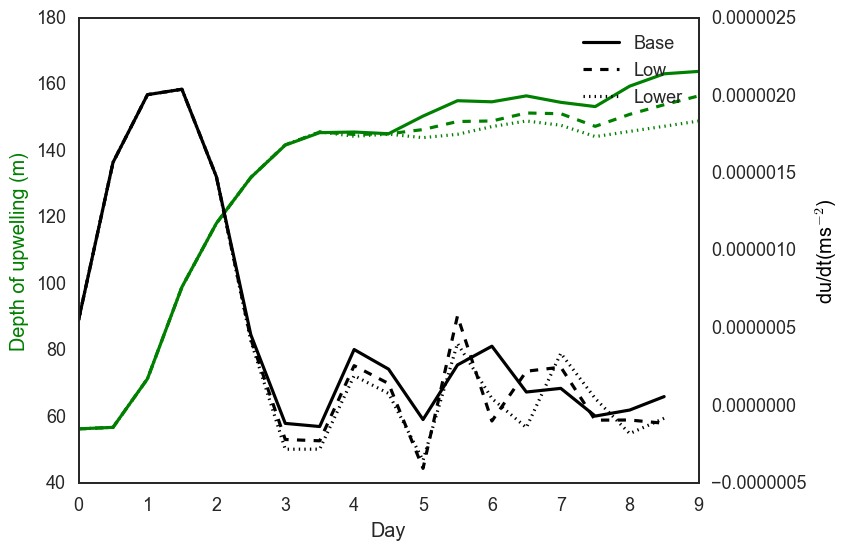

In [73]:
fig,ax1 = plt.subplots(1,1,figsize=(8,6))

ax2 = ax1.twinx()

ax1.plot(np.arange(19)/2,conc_to_depth(max_conc_base)-Hh, 'g-')
ax2.plot(np.arange(0,18,1)/2,(np.mean(np.mean(U_in_base,axis=1),axis=1).data[1:]-
                              np.mean(np.mean(U_in_base,axis=1),axis=1).data[:-1])/(3600*12), 'k-',label = 'Base')

ax1.plot(np.arange(19)/2,conc_to_depth(max_conc_low)-Hh,'g--')
ax2.plot(np.arange(0,18,1)/2, (np.mean(np.mean(U_in_lowsr,axis=1),axis=1).data[1:]-
                               np.mean(np.mean(U_in_lowsr,axis=1),axis=1).data[:-1])/(3600*12), 'k--',label = 'Low')

ax1.plot(np.arange(19)/2,conc_to_depth(max_conc_lower)-Hh, 'g:')
ax2.plot(np.arange(0,18,1)/2, (np.mean(np.mean(U_in_lowersr,axis=1),axis=1).data[1:]-
                               np.mean(np.mean(U_in_lowersr,axis=1),axis=1).data[:-1])/(3600*12), 'k:',label = 'Lower')

ax1.set_xlabel('Day')
ax1.set_ylabel('Depth of upwelling (m)', color='g')
ax2.set_ylabel('du/dt(ms$^{-2}$)', color='k')


ax2.legend(loc=0)

plt.show()
